In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [4]:
def build_oracle(marked, n):
    qc = QuantumCircuit(n + 1)
    anc = n
    for state in marked:
        # flip zeros so that only |state⟩ → all-ones
        for q in range(n):
            if ((state >> q) & 1) == 0:
                qc.x(q)
        # MCZ via H–MCX–H on ancilla
        qc.h(anc)
        qc.mcx(list(range(n)), anc)
        qc.h(anc)
        # undo X flips
        for q in range(n):
            if ((state >> q) & 1) == 0:
                qc.x(q)
        qc.barrier(range(n+1))
    return qc

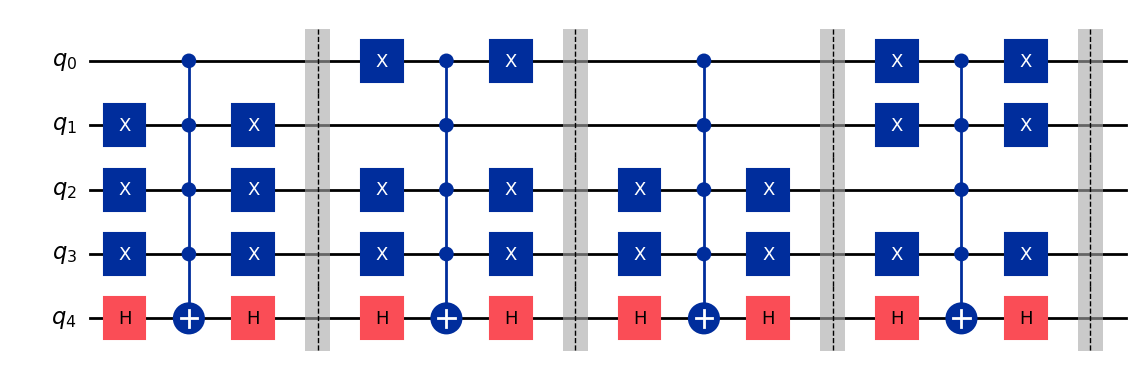

In [5]:
marked_states = [1, 2, 3, 4]

oracle = build_oracle(marked_states, 4)
oracle.draw(output="mpl", style="iqp")

In [6]:
def diffuser(n):
    qc = QuantumCircuit(n + 1)
    # H and X on index qubits only
    qc.h(range(n))
    qc.barrier(range(n+1))
    qc.x(range(n))
    # multi-controlled Z on qubit n-1
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.barrier(range(n+1))
    qc.h(range(n))
    return qc

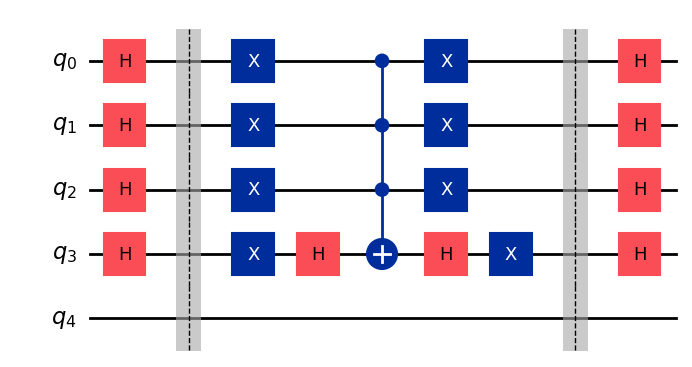

In [7]:
diffuse_gate = diffuser(4)
diffuse_gate.draw(output='mpl')

In [8]:
def grover_circuit(n, marked, k):
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)              # ancilla into |1⟩
    qc.h(range(n))       # uniform superposition on data qubits
    O = build_oracle(marked, n)
    D = diffuser(n)
    for _ in range(k):
        qc.append(O, range(n + 1))
        qc.append(D, range(n + 1))
    qc.measure(range(n), range(n))
    return qc

In [9]:
backend = AerSimulator()

def run_grover(n, marked, k, shots=4096):
    tqc = transpile(grover_circuit(n, marked, k), backend)
    counts = backend.run(tqc, shots=shots).result().get_counts()

    # bitstrings are little-endian, so direct int(bitstr,2) works
    return sum(ct for bitstr, ct in counts.items()
               if int(bitstr, 2) in marked) / shots

# Quick print sanity check (expect ~0.96)
print("Sanity check N=16, M=1, k=3 ", run_grover(4, [1], 3))

Sanity check N=16, M=1, k=3  0.9638671875


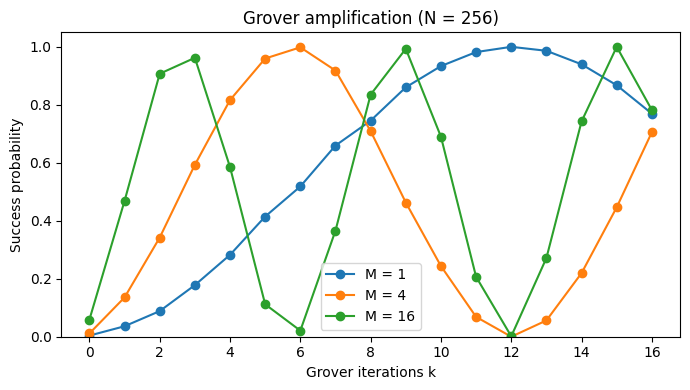

In [10]:
n = 8                # N = 256
k_vals = range(17)
plt.figure(figsize=(7,4))
for M in [1, 4, 16]:
    marked = random.sample(range(2**n), M)
    probs = [run_grover(n, marked, k) for k in k_vals]
    plt.plot(k_vals, probs, marker='o', label=f"M = {M}")
plt.xlabel("Grover iterations k")
plt.ylabel("Success probability")
plt.ylim(0,1.05)
plt.title("Grover amplification (N = 256)")
plt.legend()
plt.tight_layout()
plt.show()

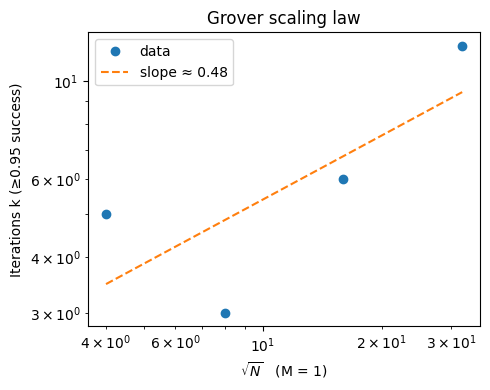

In [11]:
target = 0.95
records = []
for n in [4,6,8,10]:           # N = 16…1024
    marked = [random.randrange(2**n), random.randrange(2**n), random.randrange(2**n)]
    for k in range(1,40):
        if run_grover(n, marked, k) >= target:
            records.append((sqrt(2**n), k))
            break
x, y = zip(*records)
plt.figure(figsize=(5,4))
plt.loglog(x, y, 'o', label="data")
slope, intercept = np.polyfit(np.log10(x), np.log10(y), 1)
fit_y = 10**intercept * np.array(x)**slope
plt.loglog(x, fit_y, '--', label=f"slope ≈ {slope:.2f}")
plt.xlabel(r"$\sqrt{N}$   (M = 1)")
plt.ylabel("Iterations k (≥0.95 success)")
plt.title("Grover scaling law") 
plt.legend()
plt.tight_layout()

In [12]:
backend = AerSimulator()

def run_grover_multiple_solutions(n, marked, shots=4096):
    # run grover's for random numbers of iterations until you get one with accuracy >95%
    for _ in range(int(np.floor(np.pi * np.sqrt(2 ** n) / 4))):
        tqc = transpile(grover_circuit(n, marked, random.choice(range(int(np.floor(np.pi * np.sqrt(2 ** n) / 4))))), backend)
        counts = backend.run(tqc, shots=shots).result().get_counts()

        accuracy = sum(ct for bitstr, ct in counts.items() if int(bitstr, 2) in marked) / shots
        if accuracy > 0.95:
            print("Accuracy: ", accuracy)
            return counts
    
    print("no solution found")
    return None

def run_grover_multiple_solutions_elegant(n, marked, shots=4096):
    t = 1
    for i in range(50):
        tqc = transpile(grover_circuit(n, marked, random.choice(range(int(t)))), backend)
        counts = backend.run(tqc, shots=shots).result().get_counts()

        accuracy = sum(ct for bitstr, ct in counts.items() if int(bitstr, 2) in marked) / shots
        if accuracy > 0.99:
            print("Accuracy: ", accuracy)
            print("iterations needed: ", i)     # tracks number of iterations necessary to get >0.99 accuracy
            print("Grover iterations needed: ", k)
            return counts
        else:
            t = np.ceil(t * 1.1)
    
    # accounts for rare case in which solution is not found
    print("no solution found")
    return None


marked states:  [5]
no solution found
marked states:  [226, 194, 95, 75]
Accuracy:  0.9951171875
iterations needed:  25
Grover iterations needed:  12
marked states:  [46, 197, 155, 11, 113, 38, 32, 252, 10, 33, 147, 201, 76, 193, 157, 97]
Accuracy:  0.99365234375
iterations needed:  33
Grover iterations needed:  12


Text(0, 0.5, 'Counts')

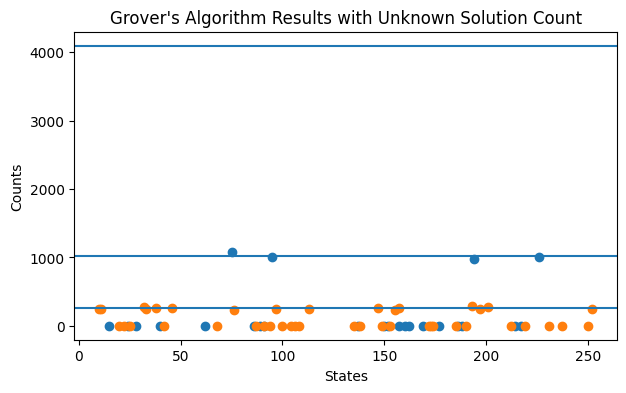

In [13]:
# Testing on multiple solutions
def binary_to_decimal(n):
    return int(n, 2)

n = 8                # N = 256
plt.figure(figsize=(7,4))
for M in [1, 4, 16]:

    # marked state is chosen at random
    marked = random.sample(range(2**n), M)
    print("marked states: ", marked)

    # plot horizontal line for where marked states should be
    plt.axhline(4096 / M)

    # run Grover's algorithm and plot frequencies of results
    counts = run_grover_multiple_solutions_elegant(n, marked)
    if counts != None:
        counts = dict(sorted(counts.items()))
        counts_keys = list(map(binary_to_decimal, counts.keys()))
        plt.scatter(counts_keys, counts.values())

plt.title("Grover's Algorithm Results with Unknown Solution Count")
plt.xlabel("States")
plt.ylabel("Counts")
